In [1]:
import os
import scipy
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib

import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

from collections import defaultdict
from IPython.display import display, HTML

import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline 
current_palette = sns.color_palette()
cmap = current_palette.as_hex()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

current_palette = sns.color_palette()
cmap = ListedColormap(current_palette.as_hex())

In [2]:
colors = {
    'deepens': '#1f77b4', 
    'dropout': '#ff7f0e',
    'kfacl': '#2ca02c',
    'onenet': '#d62728',
    'vi': '#9467bd',
    'csgld':'#8c564b',
    'sse':'#e377c2',
    'swag': '#7f7f7f', 
    'fge': '#bcbd22'}

names = {
    'acc': 'Accuracy (%)',
    'll': 'Log-Likelihood',
    'brier': 'Brier',
    'acc-aac': 'AURC'
}

names_ = {
    'deepens': 'Deep ensemble', 
    'dropout': 'Dropout',
    'kfacl': 'K-FAC-L',
    'onenet': 'Single model',
    'vi': 'FFG VI',
    'csgld':'cSGLD',
    'sse':'SSE',
    'swag': 'SWAG', 
    'fge': 'FGE'}

names_long = {
    'deepens': 'Deep Ensembles', 
    'dropout': 'Dropout',
    'kfacl': 'KFAC-Laplace',
    'onenet': 'Single model',
    'vi': 'Variational Inf. (FFG)',
    'csgld':'Cyclic SGLD',
    'sse':'Snapshot Ensembles',
    'swag': 'SWA-Gaussian', 
    'fge': 'Fast Geometric Ens.', 
    'stochbn':'SBN'}

    
precition = {
    'acc': '%.2f',
    'acc@5': '%.2f',
    'll':  '%.3f',
    'brier': '%.3f',
    'acc-aac': '%.4f',
    'dee': '%.1f'
}

# Reading log-files

In [ ]:
!unzip logs.zip > unzip_out

In [3]:
path = './logs/'
df = pd.concat([pd.read_csv(path + f) for f in os.listdir(path)], sort=False)
df.model = df.model.apply(lambda x: x.replace('do', '').replace('Bayes', ''))
df.metric = df.metric.apply(lambda x: x.replace('_', '-'))
df.method = df.method.apply(lambda x: x.lower().replace('_', '-').replace('kfaclaplace', 'kfacl'))
df = df[df.metric.apply(lambda x: x in ['acc-aac', 'acc', 'll', 'brier'])]

df.model = df.model.apply(
    lambda x: x.replace('BN', '').replace('Pre', '').replace('28x10', ''))
dfbase_ung = df
dfbase = df.groupby(
    ['dataset', 'model', 'method', 'n_samples', 'metric']
).value.agg(['mean', 'std', len]).reset_index()
dfbase = dfbase[dfbase.method.apply(lambda x: 'stochbn' not in x)]

In [4]:
dfbase.sample(frac=0.0001).head(3)

,dataset,model,method,n_samples,metric,mean,std,len
33966,CIFAR10,VGG16,onenet,92,brier,0.102627,0.001480,5.0
53971,CIFAR10,WideResNet,vi-augment,93,ll,-0.125742,0.000195,5.0
69206,CIFAR100,ResNet164,deepens (ts),2,brier,0.275663,0.002134,5.0


### How to read the table 

1. Methods (dfbase.method)
    - Available methods: ```kfacl, vi, csgld, sse, dropout, fge, swag, deepens, onenet```
    - All methods can be combined with ```'(ts)'``` substring that denotes a method with a temperature-scaling.
    - All methods can be combined with ```'-augment'``` substring that denotes test-time augmentation---one augmentation of an image per one member of an ensemble.
2. Datasets (dfbase.dataset column): 
    - Available datasets: `CIFAR100, CIFAR10, ImageNet`
3. Models (dfbase.model):
    - Available models for CIFAR-10/100: ```VGG16, ResNet110, WideResNet, ResNet164```
    - Available model for ImageNet is ```ResNet50```
4. Size of an ensemble 
    - Number of members of an ensemble (`dfbase.n_samples`) typically is 1-100 for CIFARs and 1-50 for ImageNet.
5. Metrics:
    - Available metrics: `acc, ll, brier, acc-aac`
    - Where df.mean and df.std stores mean and standard deviation.
    
### How to work with data frame 
1. We find `df.query` quite usefull. There is an example: `dfbase.query("method=='deepens' and dataset=='ImageNet' and metric=='acc' and n_samples<5")`  
2. Iteration via a data frame is also very usefull. There is an example: `for row in dfbase.values[:3]: print (row)`

# Tables

In [5]:
df = dfbase
ts = True
addlen = False
if ts: df = dfbase[dfbase.method.apply(lambda x: 'ts' in x)]
else:  df = dfbase[dfbase.method.apply(lambda x: 'ts' not in x)]
latex = True
td = defaultdict(lambda: dict())
    
for dataset_, ns_ in [('CIFAR100', 100)]:
    for metric_ in ['acc']:
        label = '%s_%s_%s' % (dataset_, metric_, ns_) 
        for i in df.values:
            dataset, model, metod, ns, metric, val, std, len_ = i 
            if '-augment' in metod: continue
            metod = metod.replace('-augment', '')
            if dataset == dataset_  and metric == metric_ and ns == ns_:
                opt_t = ' (ts)' in metod
                metod = names_[metod.replace(' (ts)', '')]
                # model += ' (%s samples)' % ns_
                if opt_t: metod = metod+'*'
                if metric == 'acc':
                    td[metod][model] = '%.2f%s' % (100*(1-val), (('±%.2f' % (std*100)) if str(std) != 'nan' else ''))
                elif metric == 'acc-aac':
                    td[metod][model] = '%.4f±%.2f' % (val, std)
                elif metric=='ll':
                    td[metod][model] = '%.3f%s' % (-val, (('±%.3f' % std) if str(std) != 'nan' else ''))
                td[metod][model].replace('nan', '')
        
        df_ = pd.DataFrame.from_dict(td) 
        df_ = df_.replace(np.nan, '', regex=True)
        cap = '%s on %s dataset for diferent number of samples' % (('c' if ts and metric_ != 'acc' else '') + names[metric_], dataset_)

        df_.columns.name = '%s' % (('Neg. ' if metric_ == 'll' else '') + names[metric_])
        display(df_)

Accuracy (%),cSGLD*,Deep ensemble*,FGE*,K-FAC-L*,Single model*,SSE*,SWAG*,FFG VI*,Dropout*
ResNet110,18.07±0.16,16.97±0.07,19.64±0.15,22.14±0.29,22.66±0.31,18.48±0.25,20.69±0.19,21.86±0.07,
ResNet164,17.13±0.18,16.50±0.01,18.73±0.25,21.03±0.38,21.39±0.40,17.68±0.07,19.48±0.19,20.82±0.04,
VGG16,21.15±0.11,19.88±0.10,22.78±0.22,25.70±0.38,25.44±0.29,21.03±0.10,22.97±0.20,24.56±0.07,25.60±0.17
WideResNet,16.29±0.10,15.77±0.04,17.12±0.16,19.43±0.21,19.31±0.24,16.07±0.07,17.08±0.19,18.74±0.08,19.22±0.15


In [6]:
df = dfbase
ts = True
addlen = False
if ts: df = dfbase[dfbase.method.apply(lambda x: 'ts' in x)]
else:  df = dfbase[dfbase.method.apply(lambda x: 'ts' not in x)]
latex = True
td = defaultdict(lambda: dict())
    
for dataset_, ns_ in [('CIFAR100', 100)]:
    for metric_ in ['acc']:
        label = '%s_%s_%s' % (dataset_, metric_, ns_) 
        for i in df.values:
            dataset, model, metod, ns, metric, val, std, len_ = i 
            if '-augment' in metod: continue
            metod = metod.replace('-augment', '')
            if dataset == dataset_  and metric == metric_ and ns == ns_:
                opt_t = ' (ts)' in metod
                metod = names_[metod.replace(' (ts)', '')]
                # model += ' (%s samples)' % ns_
                if opt_t: metod = metod+'*'
                if metric == 'acc':
                    td[model][metod] = '%.2f%s' % (100*(1-val), (('±%.2f' % (std*100)) if str(std) != 'nan' else ''))
                elif metric == 'acc-aac':
                    td[model][metod] = '%.4f±%.2f' % (val, std)
                elif metric=='ll':
                    td[model][metod] = '%.3f%s' % (-val, (('±%.3f' % std) if str(std) != 'nan' else ''))
                td[model][metod].replace('nan', '')
        
        df_ = pd.DataFrame.from_dict(td) 
        df_ = df_.replace(np.nan, '', regex=True)
        cap = '%s on %s dataset for diferent number of samples' % (('c' if ts and metric_ != 'acc' else '') + names[metric_], dataset_)

        df_.columns.name = '%s' % (('Neg. ' if metric_ == 'll' else '') + names[metric_])
        display(df_)

Accuracy (%),ResNet110,ResNet164,VGG16,WideResNet
cSGLD*,18.07±0.16,17.13±0.18,21.15±0.11,16.29±0.10
Deep ensemble*,16.97±0.07,16.50±0.01,19.88±0.10,15.77±0.04
FGE*,19.64±0.15,18.73±0.25,22.78±0.22,17.12±0.16
K-FAC-L*,22.14±0.29,21.03±0.38,25.70±0.38,19.43±0.21
Single model*,22.66±0.31,21.39±0.40,25.44±0.29,19.31±0.24
SSE*,18.48±0.25,17.68±0.07,21.03±0.10,16.07±0.07
SWAG*,20.69±0.19,19.48±0.19,22.97±0.20,17.08±0.19
FFG VI*,21.86±0.07,20.82±0.04,24.56±0.07,18.74±0.08
Dropout*,,,25.60±0.17,19.22±0.15


In [7]:
df = dfbase
ts = True
if ts: df = dfbase[dfbase.method.apply(lambda x: 'ts' in x)]
else:  df = dfbase[dfbase.method.apply(lambda x: 'ts' not in x)]

td = defaultdict(lambda: dict())
for dataset_, ns_ in [('ImageNet', 1), ('ImageNet', 10), ('ImageNet', 50)]:
    for metric_ in ['ll']:
        label = '%s_%s_%s' % (dataset_, metric_, ns_) 
        for i in df.values:
            dataset, model, metod, ns, metric, val, std, len_ = i 
            model += ' (%s)' % ns_
            if '-augment' not in metod:
                opt_t = ' (ts)' in metod
                metod = names_long[metod.replace(' (ts)', '')]
                if dataset == dataset_  and metric == metric_ and ns == ns_:
                    metod, model = model, metod
                    if metric=='ll':
                        td[metod][model] = (-val)
                    
        for i in df.values:
            dataset, model, metod, ns, metric, val, std, len_ = i 
            model += ' (%s)' % ns_
            if '-augment' in metod:         
                metod = metod.replace('-augment', '')
                if dataset == dataset_  and metric == metric_ and ns == ns_:
                    
                    opt_t = ' (ts)' in metod
                    if metric == 'll': val=-val
                    metod = names_long[metod.replace(' (ts)', '')]
                    prev = td[model][metod]
                    cur = val if metric!='acc' else (100-100*(val))
                    pm = precition[metric]
                    
                    if (pm % prev) == (pm % cur):
                        s = '≈'
                    elif prev > cur:
                        s = '↓'
                    else:
                        s = '↑'
                        
                    vs = '$%s$ vs $%s$' % (precition[metric_], precition[metric_])
                    #vs = '%s vs %s' % (precition[metric_], precition[metric_])
                    metod, model = model, metod
                    if metric == 'll':
                        td[metod][model] = vs % (prev, cur)
                    td[metod][model] += '±%.3f%s' % (std, s)
                        
                    
        
df_ = pd.DataFrame.from_dict(td)
df_ = df_.replace(np.nan, '', regex=True)
cap = '%s on %s dataset for diferent number of samples' % (('c' if ts and metric_ != 'acc' else '') + names[metric_], dataset_)

df_.columns.name = 'Ensembling Method'
display(df_)

print(df_.to_latex().replace(
    '±', '{\\tiny $\pm').replace(
    '↑', '\color{darkpink}{\\uparrow}$}').replace(
    '↓', '\color{darkpastelgreen}{\\downarrow}$}').replace('\$', '$'))

Ensembling Method,ResNet50 (1),ResNet50 (10),ResNet50 (50)
Deep Ensembles,$0.935$ vs $1.292$±0.005↑,$0.805$ vs $0.793$±0.002↓,$0.788$ vs $0.739$±0.000↓
Fast Geometric Ens.,$0.929$ vs $1.288$±0.008↑,$0.916$ vs $0.842$±0.001↓,$0.904$ vs $0.793$±0.001↓
KFAC-Laplace,$0.988$ vs $1.298$±0.008↑,$0.939$ vs $0.855$±0.005↓,$0.934$ vs $0.809$±0.004↓
Single model,$0.938$ vs $1.292$±0.006↑,$0.938$ vs $0.851$±0.004↓,$0.938$ vs $0.805$±0.003↓
Snapshot Ensembles,$0.983$ vs $1.361$±0.005↑,$0.843$ vs $0.815$±0.002↓,$0.830$ vs $0.763$±0.000↓
Variational Inf. (FFG),$0.957$ vs $1.326$±0.007↑,$0.923$ vs $0.851$±0.001↓,$0.920$ vs $0.805$±0.001↓


\begin{tabular}{llll}
\toprule
Ensembling Method &               ResNet50 (1) &              ResNet50 (10) &              ResNet50 (50) \\
\midrule
Deep Ensembles         &  $0.935$ vs $1.292${\tiny $\pm0.005\color{darkpink}{\uparrow}$} &  $0.805$ vs $0.793${\tiny $\pm0.002\color{darkpastelgreen}{\downarrow}$} &  $0.788$ vs $0.739${\tiny $\pm0.000\color{darkpastelgreen}{\downarrow}$} \\
Fast Geometric Ens.    &  $0.929$ vs $1.288${\tiny $\pm0.008\color{darkpink}{\uparrow}$} &  $0.916$ vs $0.842${\tiny $\pm0.001\color{darkpastelgreen}{\downarrow}$} &  $0.904$ vs $0.793${\tiny $\pm0.001\color{darkpastelgreen}{\downarrow}$} \\
KFAC-Laplace           &  $0.988$ vs $1.298${\tiny $\pm0.008\color{darkpink}{\uparrow}$} &  $0.939$ vs $0.855${\tiny $\pm0.005\color{darkpastelgreen}{\downarrow}$} &  $0.934$ vs $0.809${\tiny $\pm0.004\color{darkpastelgreen}{\downarrow}$} \\
Single model           &  $0.938$ vs $1.292${\tiny $\pm0.006\color{darkpink}{\uparrow}$} &  $0.938$ vs $0.851${\tiny $\pm0.004

In [8]:
dataset = 'ImageNet'
models = ['VGG16', 'ResNet110', 'ResNet164', 'WideResNet', 'ResNet50']
methods = ['dropout', 'swag', 'csgld', 'fge', 'deepens', 'onenet', 'vi', 'kfacl', 'sse']

rows, row_counter = defaultdict(lambda: dict()), 0
for model in models:
    for method in methods:
        metrics = defaultdict(lambda: dict())
        metrics_ = defaultdict(lambda: dict())
        metrics_std = defaultdict(lambda: dict())
        for line in df.values:
            dataset_, model_, method_, ns_, metric_, val_, std_, len_ = line
            if 'ts' not in method_: continue
            if 'aug' not in method_:
                method_ = method_.replace('-augment', '').replace(' (ts)', '')
                if dataset_ == dataset and model_==model and method_ == method and metric_ in precition:
                    if metric_ == 'acc':
                        metrics[metric_][ns_] = '?'+ (precition[metric_] % (100*(1-val_))) + '?'
                        std = precition[metric_] % (std_*100)
                    if metric_ == 'll':
                        metrics[metric_][ns_] = '?' + (precition[metric_] % -val_) + '?'
                        std = precition[metric_] % std_

            else:
                method_ = method_.replace('-augment', '').replace(' (ts)', '')
                if dataset_ == dataset and model_==model and method_ == method and metric_ in precition:
                    if metric_ == 'acc':
                        metrics_[metric_][ns_] = '?'+ (precition[metric_] % (100*(1-val_)))
                        metrics_std[metric_][ns_] = precition[metric_] % (std_*100)
                    if metric_ == 'll':
                        metrics_[metric_][ns_] = '?' + (precition[metric_] % -val_)
                        metrics_std[metric_][ns_] = precition[metric_] % std_

        def get_arrow(x):
            prev = metrics[x[0]][x[1]].replace('?', '')
            cur = metrics_[x[0]][x[1]].replace('?', '')
            std =  metrics_std[x[0]][x[1]]
            if prev == cur:
                s = '≈'
            elif np.abs(float(cur)-float(prev)) <= float(std):
                s = '≈'
            elif float(prev) > float(cur):
                s = '↓'
            else:
                s = '↑'
            return s

        f = lambda x: metrics[x[0]][x[1]]+vs+metrics_[x[0]][x[1]] + get_arrow(x)
        if metrics: 
            if dataset != 'ImageNet':
                rows[row_counter] = [model, names_long[method]]
                rows[row_counter] += list(map(f, [('acc', 5), ('acc', 10), ('acc', 100), ('ll', 5), ('ll', 10), ('ll', 100)]))
                columns = ['Model', 'Method', 'acc(5)', 'acc(10)', 'acc(100)', 'll(5)', 'll(10)', 'll(100)']
            else:
                rows[row_counter] = [model, names_long[method]]
                rows[row_counter] += list(map(f, [('acc', 5), ('acc', 10), ('acc', 50), ('ll', 5), ('ll', 10), ('ll', 50)]))
                columns = ['Model', 'Method', 'acc(5)', 'acc(10)', 'acc(50)', 'll(5)', 'll(10)', 'll(50)']
            row_counter+=1

In [9]:
df_ = pd.DataFrame.from_dict(rows, columns=columns, orient='index')
display(df_)

,Model,Method,acc(5),acc(10),acc(50),ll(5),ll(10),ll(50)
0,ResNet50,Fast Geometric Ens.,?23.61?$%.3f$ vs $%.3f$?22.21↓,?23.56?$%.3f$ vs $%.3f$?21.37↓,?23.28?$%.3f$ vs $%.3f$?20.67↓,?0.921?$%.3f$ vs $%.3f$?0.894↓,?0.916?$%.3f$ vs $%.3f$?0.842↓,?0.904?$%.3f$ vs $%.3f$?0.793↓
1,ResNet50,Deep Ensembles,?21.19?$%.3f$ vs $%.3f$?21.20≈,?20.90?$%.3f$ vs $%.3f$?20.16↓,?20.63?$%.3f$ vs $%.3f$?19.39↓,?0.823?$%.3f$ vs $%.3f$?0.855↑,?0.805?$%.3f$ vs $%.3f$?0.793↓,?0.788?$%.3f$ vs $%.3f$?0.739↓
2,ResNet50,Single model,?23.86?$%.3f$ vs $%.3f$?22.39↓,?23.86?$%.3f$ vs $%.3f$?21.60↓,?23.86?$%.3f$ vs $%.3f$?21.06↓,?0.938?$%.3f$ vs $%.3f$?0.900↓,?0.938?$%.3f$ vs $%.3f$?0.851↓,?0.938?$%.3f$ vs $%.3f$?0.805↓
3,ResNet50,Variational Inf. (FFG),?23.82?$%.3f$ vs $%.3f$?22.58↓,?23.77?$%.3f$ vs $%.3f$?21.74↓,?23.67?$%.3f$ vs $%.3f$?21.10↓,?0.927?$%.3f$ vs $%.3f$?0.905↓,?0.923?$%.3f$ vs $%.3f$?0.851↓,?0.920?$%.3f$ vs $%.3f$?0.805↓
4,ResNet50,KFAC-Laplace,?24.19?$%.3f$ vs $%.3f$?22.50↓,?23.93?$%.3f$ vs $%.3f$?21.67↓,?23.86?$%.3f$ vs $%.3f$?21.04↓,?0.948?$%.3f$ vs $%.3f$?0.906↓,?0.939?$%.3f$ vs $%.3f$?0.855↓,?0.934?$%.3f$ vs $%.3f$?0.809↓
5,ResNet50,Snapshot Ensembles,?22.21?$%.3f$ vs $%.3f$?21.99↓,?21.75?$%.3f$ vs $%.3f$?20.81↓,?21.48?$%.3f$ vs $%.3f$?19.86↓,?0.865?$%.3f$ vs $%.3f$?0.879↑,?0.843?$%.3f$ vs $%.3f$?0.815↓,?0.830?$%.3f$ vs $%.3f$?0.763↓


In [10]:
print(df_.to_latex(index=False).replace(
    '±', '{\\tiny $\pm ').replace(
    '!', '$}').replace(
    '?', '$').replace('NAacc', '\\text{NA}\hspace{5pt}').replace('NAll', '\\text{NA}\hspace{8pt}').replace(
    '↑', '_{\color{darkpink}{\\uparrow}}$').replace(
    '↓', '_{\color{darkpastelgreen}{\\downarrow}}$').replace(
    '≈', '_{\color{darkgray}{\\approx}}$'))

\begin{tabular}{llllllll}
\toprule
    Model &                  Method &                          acc(5) &                         acc(10) &                         acc(50) &                           ll(5) &                          ll(10) &                          ll(50) \\
\midrule
 ResNet50 &     Fast Geometric Ens. &  $23.61$\$\%.3f\$ vs \$\%.3f\$$22.21_{\color{darkpastelgreen}{\downarrow}}$ &  $23.56$\$\%.3f\$ vs \$\%.3f\$$21.37_{\color{darkpastelgreen}{\downarrow}}$ &  $23.28$\$\%.3f\$ vs \$\%.3f\$$20.67_{\color{darkpastelgreen}{\downarrow}}$ &  $0.921$\$\%.3f\$ vs \$\%.3f\$$0.894_{\color{darkpastelgreen}{\downarrow}}$ &  $0.916$\$\%.3f\$ vs \$\%.3f\$$0.842_{\color{darkpastelgreen}{\downarrow}}$ &  $0.904$\$\%.3f\$ vs \$\%.3f\$$0.793_{\color{darkpastelgreen}{\downarrow}}$ \\
 ResNet50 &          Deep Ensembles &  $21.19$\$\%.3f\$ vs \$\%.3f\$$21.20_{\color{darkgray}{\approx}}$ &  $20.90$\$\%.3f\$ vs \$\%.3f\$$20.16_{\color{darkpastelgreen}{\downarrow}}$ &  $20.63$\$\%.3f\$ vs \

In [11]:
dataset = 'ImageNet'
models = ['VGG16', 'ResNet110', 'ResNet164', 'WideResNet', 'ResNet50']
methods = ['dropout', 'swag', 'csgld', 'fge', 'deepens', 'onenet', 'vi', 'kfacl', 'sse']

rows, row_counter = defaultdict(lambda: dict()), 0
for model in models:
    for method in methods:
        metrics = defaultdict(lambda: dict())
        for line in df.values:
            dataset_, model_, method_, ns_, metric_, val_, std_, len_ = line
            if 'ts' not in method_: continue
            if 'aug' in method_: continue
            method_ = method_.replace('-augment', '').replace(' (ts)', '')
            if dataset_ == dataset and model_==model and method_ == method and metric_ in precition:
                if metric_ == 'acc':
                    metrics[metric_][ns_] = '?'+ (precition[metric_] % (100*(1-val_))) + '?'
                    std = precition[metric_] % (std_*100)
                if metric_ == 'll':
                    metrics[metric_][ns_] = '?' + (precition[metric_] % -val_) + '?'
                    std = precition[metric_] % std_
                                
                if (method == 'deepens' and '10' in dataset and ns_==100) or (
                        dataset=='ImageNet' and method_ == 'sse') or (
                        dataset=='ImageNet' and method_ == 'deepens' and ns_==50):
                        std = ('NAacc' if metric_ == 'acc' else 'NAll')
                
                if metric_ in metrics and ns_ in metrics[metric_]: 
                    metrics[metric_][ns_] += ('±' + std + '!')
                
        if metrics: 
            if dataset != 'ImageNet':
                rows[row_counter] = [
                    model, names_long[method], 
                    metrics['acc'][1], metrics['acc'][5], metrics['acc'][10], metrics['acc'][100],
                    metrics['ll'][1],  metrics['ll'][5], metrics['ll'][10],  metrics['ll'][100]]
                columns = ['Model', 'Method', 'acc(1)', 'acc(5)', 'acc(10)', 'acc(100)', 'll(1)', 'll(5)', 'll(10)', 'll(100)']
            else:
                rows[row_counter] = [
                    model, names_long[method], 
                    metrics['acc'][1], metrics['acc'][5], metrics['acc'][10], metrics['acc'][50],
                    metrics['ll'][1],  metrics['ll'][5], metrics['ll'][10],  metrics['ll'][50]]
                columns = ['Model', 'Method', 'acc(1)', 'acc(5)', 'acc(10)', 'acc(50)', 'll(1)', 'll(5)', 'll(10)', 'll(50)']
            row_counter+=1

In [12]:
df_ = pd.DataFrame.from_dict(rows, columns=columns, orient='index')
print(df_.to_latex(index=False).replace(
    '±', '{\\tiny $\pm ').replace(
    '!', '$}').replace(
    '?', '$').replace('NAacc', '\\text{NA}\hspace{5pt}').replace('NAll', '\\text{NA}\hspace{8pt}'))

\begin{tabular}{llllllllll}
\toprule
    Model &                  Method &          acc(1) &          acc(5) &         acc(10) &         acc(50) &           ll(1) &           ll(5) &          ll(10) &          ll(50) \\
\midrule
 ResNet50 &     Fast Geometric Ens. &   $23.71${\tiny $\pm 0.00$} &   $23.61${\tiny $\pm 0.00$} &   $23.56${\tiny $\pm 0.00$} &   $23.28${\tiny $\pm 0.00$} &  $0.929${\tiny $\pm 0.000$} &  $0.921${\tiny $\pm 0.000$} &  $0.916${\tiny $\pm 0.000$} &  $0.904${\tiny $\pm 0.000$} \\
 ResNet50 &          Deep Ensembles &   $23.79${\tiny $\pm 0.14$} &   $21.19${\tiny $\pm 0.14$} &   $20.90${\tiny $\pm 0.08$} &  $20.63${\tiny $\pm \text{NA}\hspace{5pt}$} &  $0.935${\tiny $\pm 0.007$} &  $0.823${\tiny $\pm 0.002$} &  $0.805${\tiny $\pm 0.000$} &   $0.788${\tiny $\pm \text{NA}\hspace{8pt}$} \\
 ResNet50 &            Single model &   $23.86${\tiny $\pm 0.20$} &   $23.86${\tiny $\pm 0.20$} &   $23.86${\tiny $\pm 0.20$} &   $23.86${\tiny $\pm 0.20$} &  $0.938${\tiny $\pm 0.

# Bar plots

In [ ]:
!unzip df_dee_no_augment.csv.zip > unzip_out

In [13]:
df = pd.read_csv('./df_dee_no_augment.csv')
df.model = df.model.apply(lambda x: x.replace('do', '').replace('Bayes', ''))
df.metric = df.metric.apply(lambda x: x.replace('_', '-'))
df.method = df.method.apply(lambda x: x.lower().replace('_', '-').replace('kfaclaplace', 'kfacl'))

df.model = df.model.apply(
    lambda x: x.replace('BN', '').replace('Pre', '').replace('28x10', ''))
df = df[df.method.apply(lambda x: 'ts' in x)]
df = df[df.method.apply(lambda x: 'aug' not in x)]
df = df[df.method != 'stochbn']
df = df[df.metric == 'll']
df.value = df.dee
df.metric = len(df.dee)*['dee']

df.method = df.method.apply(lambda x: x.replace('-augment', '').replace(' (ts)', ''))

/Users/ars/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


In [14]:
df.head()

,Unnamed: 0,dataset,model,method,n_samples,metric,dee,lower,upper
700,700,CIFAR10,VGG16,dropout,1,dee,1.000000,1.0,1.000000
701,701,CIFAR10,VGG16,dropout,2,dee,1.000000,1.0,1.000000
702,702,CIFAR10,VGG16,dropout,3,dee,1.000000,1.0,1.021788
703,703,CIFAR10,VGG16,dropout,4,dee,1.006517,1.0,1.044008
704,704,CIFAR10,VGG16,dropout,5,dee,1.023056,1.0,1.061072


In [15]:
dataset = 'ImageNet'
models = ['VGG16', 'ResNet110', 'ResNet164', 'WideResNet', 'ResNet50']
methods = ['deepens', 'sse', 'csgld', 'swag', 'fge', 'dropout', 'vi', 'kfacl', 'onenet']

rows, row_counter = defaultdict(lambda: dict()), 0
for model in models:
    for method in methods:
        metrics = defaultdict(lambda: dict())
        metrics_ = defaultdict(lambda: dict())
        metrics_std = defaultdict(lambda: dict())
        for line in df.values:
            _, dataset_, model_, method_, ns_, metric_, val_, std_, len_ = line
            method_ = method_.replace('-augment', '').replace(' (ts)', '')
            if dataset_ == dataset and model_==model and method_ == method:
                metrics[metric_][ns_] = '?' + (precition[metric_] % val_) + '?'
                std = precition[metric_] % std_

        f = lambda x: metrics[x[0]][x[1]]
        if metrics: 
            if dataset != 'ImageNet':
                rows[row_counter] = [model, names_long[method]]
                rows[row_counter] += list(map(f, [('dee', 1), ('dee', 5), ('dee', 10), ('dee', 50), ('dee', 100)]))
                columns = ['Model', 'Method', 'dee(1)', 'dee(5)', 'dee(10)', 'dee(50)', 'dee(100)']
            else:
                rows[row_counter] = [model, names_long[method]]
                rows[row_counter] += list(map(f, [('dee', 1), ('dee', 5), ('dee', 10), ('dee', 25), ('dee', 50)]))
                columns = ['Model', 'Method', 'dee(1)', 'dee(5)', 'dee(10)', 'dee(25)', 'dee(50)']
            row_counter+=1
df_ = pd.DataFrame.from_dict(rows, columns=columns, orient='index')

In [16]:
df_ = pd.DataFrame.from_dict(rows, columns=columns, orient='index')
print(df_.to_latex(index=False).replace('?', '$'))

\begin{tabular}{lllllll}
\toprule
    Model &                  Method & dee(1) & dee(5) & dee(10) & dee(25) & dee(50) \\
\midrule
 ResNet50 &          Deep Ensembles &  $1.0$ &  $5.0$ &  $10.0$ &  $25.0$ &  $50.0$ \\
 ResNet50 &      Snapshot Ensembles &  $1.0$ &  $2.2$ &   $3.2$ &   $4.0$ &   $4.2$ \\
 ResNet50 &     Fast Geometric Ens. &  $1.1$ &  $1.2$ &   $1.3$ &   $1.4$ &   $1.5$ \\
 ResNet50 &  Variational Inf. (FFG) &  $1.0$ &  $1.1$ &   $1.2$ &   $1.2$ &   $1.2$ \\
 ResNet50 &            KFAC-Laplace &  $1.0$ &  $1.0$ &   $1.0$ &   $1.0$ &   $1.0$ \\
 ResNet50 &            Single model &  $1.0$ &  $1.0$ &   $1.0$ &   $1.0$ &   $1.0$ \\
\bottomrule
\end{tabular}



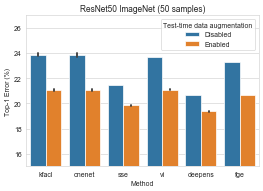

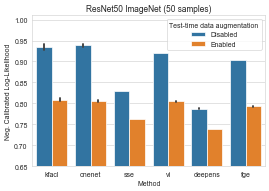

In [21]:
df = dfbase_ung

q    = 'dataset == "%s" and model == "%s" and metric == "%s" and n_samples == 50'
df  = df.query(q % ('ImageNet', 'ResNet50', 'acc'))
df = df[df.method.apply(lambda x: 'ts' in x)]
df['Test-time data augmentation'] = df.method.apply(lambda x: 'Enabled' if 'augment' in x else 'Disabled')
df.method = df.method.apply(lambda x: x.replace('-augment', '').replace(' (ts)', ''))
df['Top-1 Error (%)'] = 100*(1-df['value'].values)
df['Method'] = df['method']

mpl.rcParams['figure.dpi'] = 50
plt.title('ResNet50 ImageNet (50 samples)')
ax = sns.barplot(x="Method", y="Top-1 Error (%)", hue='Test-time data augmentation', data=df)

plt.ylim(15, 27)
plt.savefig('./pdf/barplot-err.pdf',bbox_inches='tight', pad_inches=0.05)

plt.figure()
df = dfbase_ung

q    = 'dataset == "%s" and model == "%s" and metric == "%s" and n_samples == 50'
df  = df.query(q % ('ImageNet', 'ResNet50', 'll'))
df = df[df.method.apply(lambda x: 'ts' in x)]
df['Test-time data augmentation'] = df.method.apply(lambda x: 'Enabled' if 'augment' in x else 'Disabled')
df.method = df.method.apply(lambda x: x.replace('-augment', '').replace(' (ts)', ''))
df['Neg. Calibrated Log-Likelihood'] = -df['value'].values
df['Method'] = df['method']
df = df[df.method != 'stochbn']

mpl.rcParams['figure.dpi'] = 50
plt.title('ResNet50 ImageNet (50 samples)')
ax = sns.barplot(x="Method", y="Neg. Calibrated Log-Likelihood", hue='Test-time data augmentation', data=df)

plt.ylim(0.65, 1.01)
plt.savefig('./pdf/barplot-cll.pdf',bbox_inches='tight', pad_inches=0.05)

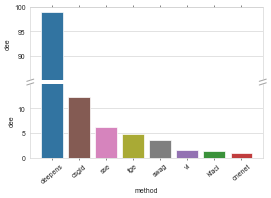

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.subplots_adjust(hspace=0.05) 

df = pd.read_csv('./df_dee_no_augment.csv')
df = df[df.method.apply(lambda x: 'ts' in x)]
df = df[df.method.apply(lambda x: 'augment' not in x)]
df.method = df.method.apply(lambda x: x.replace('-augment', '').replace(' (ts)', '').replace('kfaclaplace', 'kfacl'))
df = df[df.method != 'stochbn']
# df = df[df.method != 'deepens']

q    = 'dataset == "%s" and model == "%s" and metric == "%s" and n_samples == 100'
df  = df.query(q % ('CIFAR100', 'PreResNet110', 'll'))
sns.barplot(x="method", y="dee", data=df, palette=colors, 
                 order=['deepens', 'csgld', 'sse', 'fge', 'swag', 'vi', 'kfacl', 'onenet'], ax=ax1)
sns.barplot(x="method", y="dee", data=df, palette=colors, 
                 order=['deepens', 'csgld', 'sse', 'fge', 'swag', 'vi', 'kfacl', 'onenet'], ax=ax2)


# zoom-in / limit the view to different portions of the data
ax1.set_ylim(85.1, 100)  # outliers only
ax2.set_ylim(0, 14.9)  # most of the data

ax1.set_xlabel('')

# # hide the spines between ax and ax2

ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='gray', alpha=0.7, clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xticks(rotation=40)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.savefig('./pdf/barplot-dee.pdf',bbox_inches='tight', pad_inches=0.05)